<h1 style="text-align: center;">A Matter of Mind: Pepito’s Cognitive Challenge and Dr. Cajal’s Skepticism</h1>

### Main Question
**Is Cognitive Fatigue Quantifiable in Wikipedia Speedia, and What Role Does It Play in Gameplay?**

### Research Questions
Recent studies show that our attention spans are shrinking, and our brains can become fatigued within minutes of focused activity [(1)](https://doi.org/10.1111/psyp.12339). This project aims to investigate user engagement with Wikispeedia **game from a neuroscientific angle**, focusing on how article complexity impacts cognitive load and behaviour. Key questions include: 
- How does the complexity of articles affect user engagement? 
- Does the structure and layout (e.g., headings, multimedia) influence time spent, back-clicks, or path abandonment? 
- Is cognitive fatigue a factor in users abandoning navigation paths, such as in the "Wikipedia Game"?

### Notebook Structure
In the following notebook, the main results from the data preprocessing, exploratory data analysis, and subsequent analyses will be reported. The goal is to keep the explanations concise and focus only on the most relevant code.

As a result, many times we will upload pre-processed data frames or datasets directly. Naturally, for each section that uses these pre-processed datasets, we will link to the corresponding Jupyter notebook with the relevant data. The entire set of Jupyter notebooks can be found [here](src/notebooks).



***

# Preprocess data

The first step of the pipeline involved preprocessing the raw data. Here, we uploaded the already preprocessed data, but the specific steps followed can be found in the [0_create_df.ipynb](src/notebooks/0_create_df.ipynb) notebook.

From now on, we will use the following terminology:
- **Path**: A set of articles that leads to a curve to another article. A path can be both finished or unfinished.
- **Article**: A single webpage.

For clarity, we report the steps followed in preprocessing for each piece of data:

### 1. Articles Names
- Decoded article names.
- Added a numerical order encoding.

### 2. Article Category
- Decoded article names.
- Split the hierarchical categories into three different columns for each article.
- Removed duplicated articles (decision was to maintain only the first appearance).
- Manually added categories for 6 missing articles.

### 3. Article Links in Network
- Added columns with decoded article names.

### 4. Paths
- Finished and unfinished paths were merged into a single dataframe, paying attention to creating a column indicating whether the path is finished or not.
- For each path, **new metrics** were calculated (e.g., frequency of backlinks), which will be defined later.
- Paths were transformed into a list of articles (for better encoding) and encoded using numerical values.
- Backclicks were corrected. For instance, instead of having "<", the correct article was substituted.
- Incorrect paths were removed. These included:
    - Paths consisting of only one node.
    - Unfinished paths where the target article is not between the valid articles.
    - Paths where the initial and final articles are the same.
    - Paths with a duration of 0 or greater than 5000.

### 5. BFS Matrix
- The BFS matrix was transformed into a dataframe to better work with it.

Lastly a serach of NaN values was perfomed, highlighting only 3 paths with a NaN hashed IP address.


In [172]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import ast
from scipy.stats import pointbiserialr
from collections import Counter

print(os.getcwd())

/Users/adamouazzani/Documents/GitHub/ada-2024-project-theadacuates


In [202]:
df_path = pd.read_csv("data/output/processed_data/paths_processed.csv", low_memory=False)
df_article = pd.read_csv("data/output/processed_data/articles_processed.csv")
df_raw = pd.read_csv('./data/output/base_data/raw_processed.csv')
df_categories = pd.read_csv('./data/output/processed_data/categories_processed.csv')

/var/folders/fn/4xlpvr555jx0gt6033j7x9lr0000gn/T/ipykernel_29288/630893400.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('./data/output/base_data/raw_processed.csv')


# Exploratory Data Analysis

## 1. Comparison of raw data with processed data

In [174]:
raw_row_count = df_raw.shape[0]
processed_row_count = df_path.shape[0]
removed_paths = raw_row_count - processed_row_count

print(f"Total rows in raw data: {raw_row_count}")
print(f"Total rows in processed data: {processed_row_count}")
print(f"Paths removed during preprocessing: {removed_paths}")


Total rows in raw data: 76193
Total rows in processed data: 74114
Paths removed during preprocessing: 2079


In [175]:
# Count finished vs. unfinished in raw data
raw_finished_counts = df_raw['finished'].value_counts()
print("Raw Data - Finished/Unfinished Counts:\n", raw_finished_counts)

# Count finished vs. unfinished in processed data
processed_finished_counts = df_path['finished'].value_counts()
print("Processed Data - Finished/Unfinished Counts:\n", processed_finished_counts)


Raw Data - Finished/Unfinished Counts:
 finished
True     51318
False    24875
Name: count, dtype: int64
Processed Data - Finished/Unfinished Counts:
 finished
True     51280
False    22834
Name: count, dtype: int64


In [176]:
# Calculate percentage of finished vs. unfinished paths in each dataset
raw_finished_ratio = raw_finished_counts[True] / raw_row_count
processed_finished_ratio = processed_finished_counts[True] / processed_row_count

print(f"Percentage of finished paths in raw data: {raw_finished_ratio:.2%}")
print(f"Percentage of finished paths in processed data: {processed_finished_ratio:.2%}")

Percentage of finished paths in raw data: 67.35%
Percentage of finished paths in processed data: 69.19%


### Conlusion : 

During data preprocessing, we removed 2,079 paths, bringing the total down from 76,193 to 74,114. This process slightly increased the proportion of finished paths, going from 67.35% in the raw data to 69.19% in the processed data. More unfinished paths were filtered out from the data.

After analyzing the distribution of finished and unfinished paths, we conclude that rebalancing the data between these two categories is unnecessary. The current dataset's proportion of finished to unfinished paths reflects real user behavior and naturally occurring navigation patterns. Adjusting these proportions would risk distorting the genuine trends and insights we aim to capture.

## 2. Description of the provided features and created features

- **hashed_ip**: An anonymized identifier for the user, generated from the IP address. This allows tracking of unique users across sessions without compromising privacy.

- **timestamp**: The Unix timestamp representing the starting time of the session. It can be converted to a human-readable date and time, useful for time-based analysis like identifying active hours or days.

- **duration**: The time spent on the path in seconds. This can indicate how long users took to complete or attempt the path, possibly reflecting the difficulty or engagement level.

- **path**: A semicolon-separated string representing the sequence of pages the user visited in the session. This is the raw path data, providing insights into user navigation through the network.

- **rating**: A numeric rating given to the session by the user, possibly indicating satisfaction or perceived value of the session.

- **path_list**: The path represented as a list of page names. This makes it easier to work with individual pages in the path programmatically, especially when analyzing specific steps within each path.

- **source_link**: The starting page of the path, indicating where the user initiated navigation. This is useful for understanding common starting points in the dataset.

- **target_link**: The ending page of the path, showing the final destination in the user’s navigation. Analyzing target pages can reveal common endpoints.

- **finished**: A boolean indicating whether the path was completed (`True`) or not (`False`). This helps to differentiate between successful and abandoned sessions.

- **type_unfinished**: If the path is not finished, this field may indicate the reason for abandonment (e.g., `timeout` or `restart`). Useful for analyzing reasons behind incomplete sessions.

- **n_click**: The total number of clicks or pages visited in the path. This metric can help determine the length and complexity of each session.

- **n_back**: The number of times the user clicked back to a previous page in the session. This might indicate difficulty or indecision in finding the desired page.

- **date**: A human-readable date derived from the timestamp, enabling analysis based on specific dates or timeframes.

- **click_rate**: The rate of clicks per second, calculated as `n_click / duration`. Higher click rates could suggest faster, possibly less engaged navigation, while lower rates might imply more careful exploration.

- **normalized_duration**: The average time spent per click, calculated as `duration / n_click`. This metric can indicate the depth of engagement with each page visited.

- **freq_back**: The frequency of back clicks relative to the total number of clicks, calculated as `n_back / n_click`. A high frequency might indicate uncertainty or difficulty in navigation.

- **path_list_id**: A list of unique identifiers for each page in `path_list`, represented as numeric IDs. This provides a more efficient way to reference pages programmatically.

- **resolved_path_list_id**: Similar to `path_list_id`, containing the page IDs after any necessary transformations or resolutions. Useful for consistent analysis when page names may vary.

- **resolved_path_list_name**: The final list of page names in the path after transformations, ensuring consistency in names across the dataset. This is the definitive path used for analysis.


## 3. Exploration of the most visited pages

In [183]:
# Convert path_list strings to actual lists if necessary
df_path['resolved_path_list_name'] = df_path['resolved_path_list_name'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of pages and count occurrences of each page
all_pages = [page for path in df_path['resolved_path_list_name'] for page in path]
page_counts = Counter(all_pages)
top_20_pages = page_counts.most_common(20)

In [185]:
# Flatten the list of pages and count occurrences of each page
all_pages = [page for path in df_path['resolved_path_list_name'] for page in path]
page_counts = Counter(all_pages)

# Calculate total visits across all pages
total_visits = sum(page_counts.values())

# Calculate the visits for the top 20 pages
top_20_visits = sum(count for page, count in top_20_pages)

# Calculate the proportion of visits accounted for by the top 20 pages
top_20_proportion = top_20_visits / total_visits

print(f"\nThe Top 20 pages account for {top_20_proportion:.2%} of total visits in the game.")



The Top 20 pages account for 15.47% of total visits in the game.


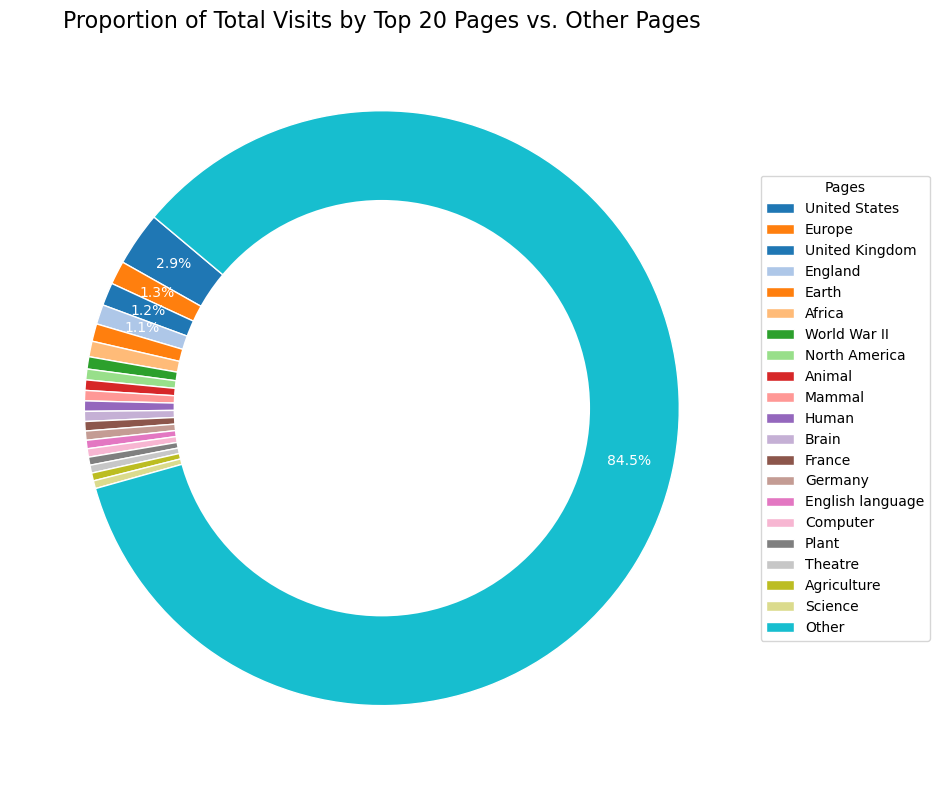

In [186]:
# Extract data for the top 20 pages
top_20_labels = [page for page, count in top_20_pages]
top_20_counts = [count for page, count in top_20_pages]

# Calculate the "Other" category for pages not in the top 20
other_count = total_visits - top_20_visits

# Add "Other" to the labels and counts
top_20_labels.append('Other')
top_20_counts.append(other_count)

# Define colors for the largest segments manually, then add a distinct palette for the remaining smaller segments
large_colors = ['#1f77b4', '#ff7f0e']  # e.g., blue and orange for the largest slices
remaining_colors = sns.color_palette('tab20', len(top_20_labels) - len(large_colors))
colors = large_colors + remaining_colors

# Plot a donut chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    top_20_counts,
    labels=[''] * len(top_20_labels),  # Remove text labels from slices
    autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',  # Only show % for slices >1%
    startangle=140,
    colors=colors,
    pctdistance=0.85,  # Increase distance of percentages from the center
    wedgeprops={'edgecolor': 'w'}
)

# Draw a circle at the center to make it a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Adjust font size and color of the percentage labels for visibility
for i, autotext in enumerate(autotexts):
    autotext.set_fontsize(10)
    autotext.set_color('white')
    # Add label name on the largest segment
    if top_20_labels[i] == 'Other':  # Assuming "Other" is the largest segment
        texts[i].set_text("Other")   # Add "Other" label on the largest slice
        texts[i].set_fontsize(12)
        texts[i].set_color('white')

# Add a legend with page names and counts for clarity
handles, _ = wedges, top_20_labels
plt.legend(handles, top_20_labels, title="Pages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Add title
plt.title('Proportion of Total Visits by Top 20 Pages vs. Other Pages', fontsize=16)
plt.tight_layout()
plt.show()


## How often is each article accessed and exited during the game?

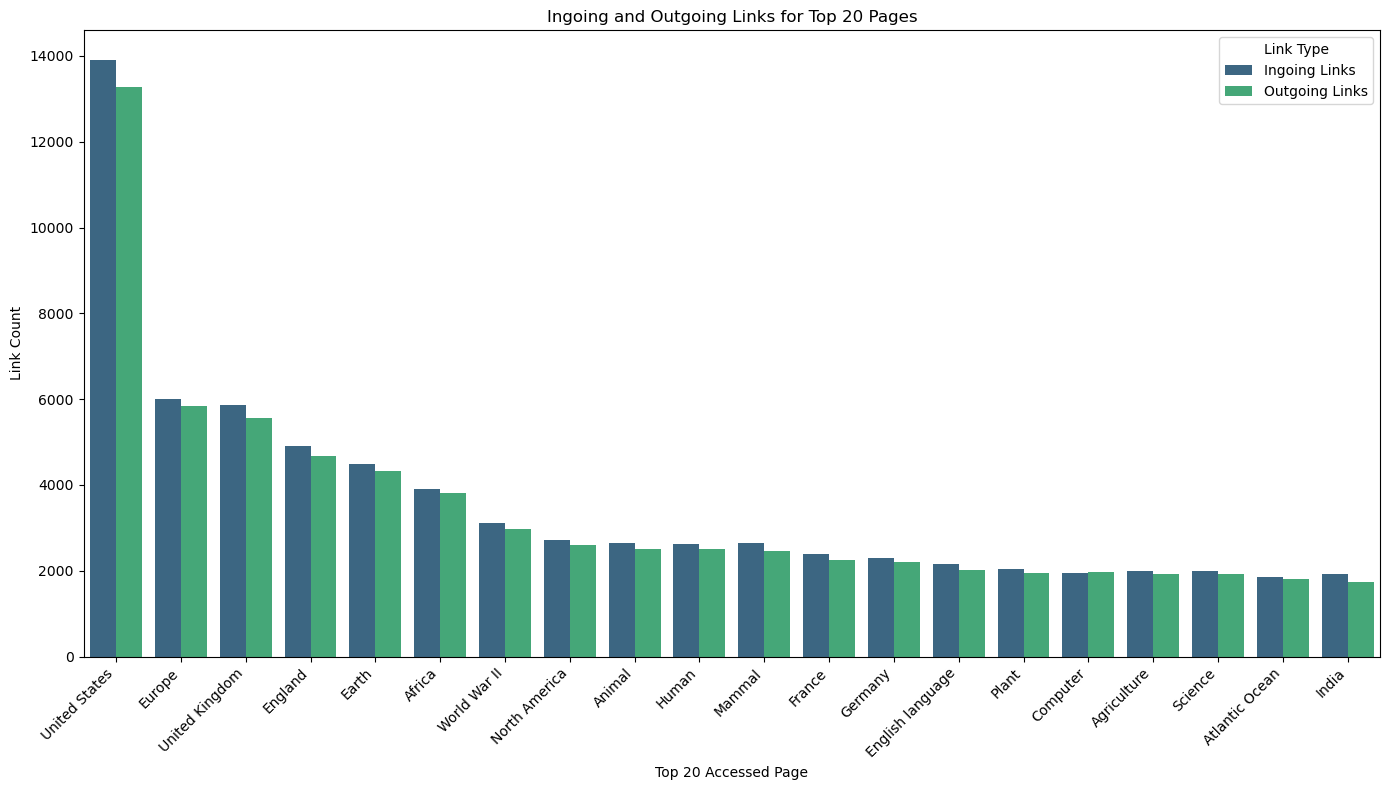

In [189]:
# Convert path_list strings to actual lists if necessary
df_path['resolved_path_list_name'] = df_path['resolved_path_list_name'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of all links to get outgoing and ingoing link pairs
outgoing_links = []
ingoing_links = []

for path in df_path['resolved_path_list_name']:
    for i in range(len(path) - 1):
        source = path[i]
        target = path[i + 1]
        outgoing_links.append(source)
        ingoing_links.append(target)

# Count outgoing and ingoing links
outgoing_counts = Counter(outgoing_links)
ingoing_counts = Counter(ingoing_links)

# Get the top 20 pages based on the total counts of each page
page_counts = outgoing_counts + ingoing_counts  # Combine counts from both directions
top_20_pages = [page for page, count in page_counts.most_common(20)]

# Prepare data for bar plot
top_20_ingoing = [ingoing_counts.get(page, 0) for page in top_20_pages]
top_20_outgoing = [outgoing_counts.get(page, 0) for page in top_20_pages]

# Create a DataFrame for easy plotting with Seaborn
link_data = pd.DataFrame({
    'Page': top_20_pages,
    'Ingoing Links': top_20_ingoing,
    'Outgoing Links': top_20_outgoing
})

# Melt the DataFrame for a grouped bar plot
link_data_melted = link_data.melt(id_vars="Page", var_name="Link Type", value_name="Count")

# Plot the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x="Page", y="Count", hue="Link Type", data=link_data_melted, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Ingoing and Outgoing Links for Top 20 Pages")
plt.xlabel("Top 20 Accessed Page")
plt.ylabel("Link Count")
plt.legend(title="Link Type")
plt.tight_layout()
plt.show()

### descriotion


In [92]:
# Calculate total ingoing and outgoing links
total_outgoing = sum(outgoing_counts.values())
total_ingoing = sum(ingoing_counts.values())

# Calculate ingoing and outgoing links for the top 20 pages
top_20_outgoing = sum(outgoing_counts.get(page, 0) for page in top_20_pages)
top_20_ingoing = sum(ingoing_counts.get(page, 0) for page in top_20_pages)

# Calculate percentages
outgoing_percentage = (top_20_outgoing / total_outgoing) * 100 if total_outgoing > 0 else 0
ingoing_percentage = (top_20_ingoing / total_ingoing) * 100 if total_ingoing > 0 else 0

# Display results
print("Percentage of total clicks accounted for by the top 20 pages:")
print(f"Outgoing Links: {outgoing_percentage:.2f}%")
print(f"Ingoing Links: {ingoing_percentage:.2f}%")


Percentage of total clicks accounted for by the top 20 pages:
Outgoing Links: 17.29%
Ingoing Links: 17.16%


## 4. Exploring Categories

 ALL CAT EXPLANTION


In [203]:
# Load categories data 
df_categories = df_categories[['article_name', 'article_category_1']]
df_categories = df_categories.rename(columns={'article_category_1': 'primary_category'})

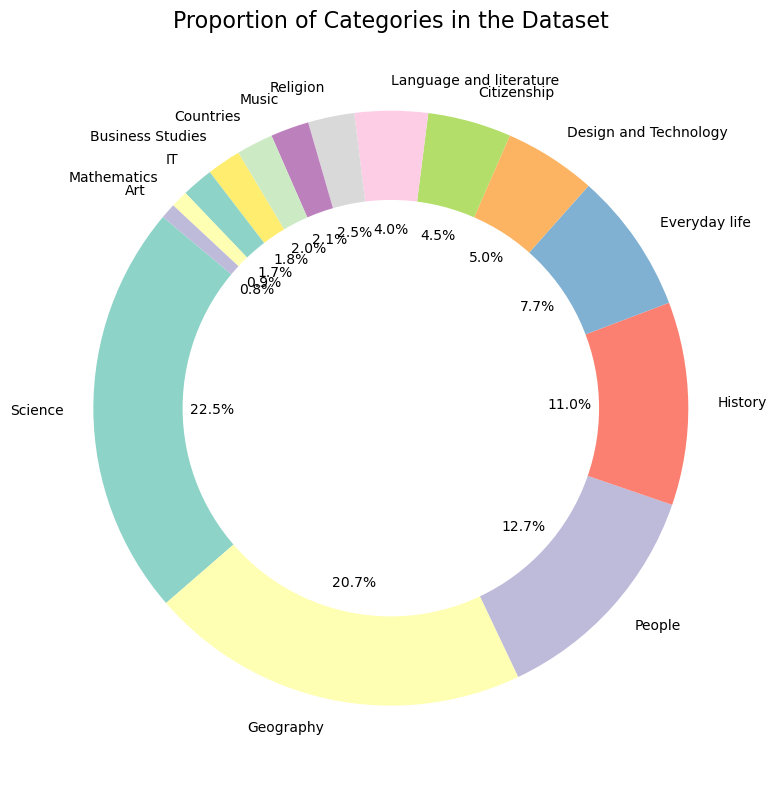

In [204]:
# Count the occurrences of each category before merging
category_counts = df_categories['primary_category'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette('Set3', len(category_counts))  # Choose a color palette
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Draw a circle at the center to make it a donut chart (optional)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Add title and adjust layout
plt.title('Proportion of Categories in the Dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [205]:
# Remove duplicates to ensure each article has a unique category
df_categories = df_categories.drop_duplicates(subset=['article_name'])

# Merge to add start category based on `source_link`
df_path = df_path.merge(
    df_categories,
    left_on='source_link',
    right_on='article_name',
    how='left'
).rename(columns={'primary_category': 'start_category'})

# Merge to add end category based on `target_link`
df_path = df_path.merge(
    df_categories,
    left_on='target_link',
    right_on='article_name',
    how='left'
).rename(columns={'primary_category': 'end_category'})

# Drop redundant columns from merging
df_path = df_path.drop(columns=['article_name_x', 'article_name_y'])

# Count paths that start in one category and end in another
category_path_counts = df_path.groupby(['start_category', 'end_category']).size().unstack(fill_value=0)



 explain wht it is

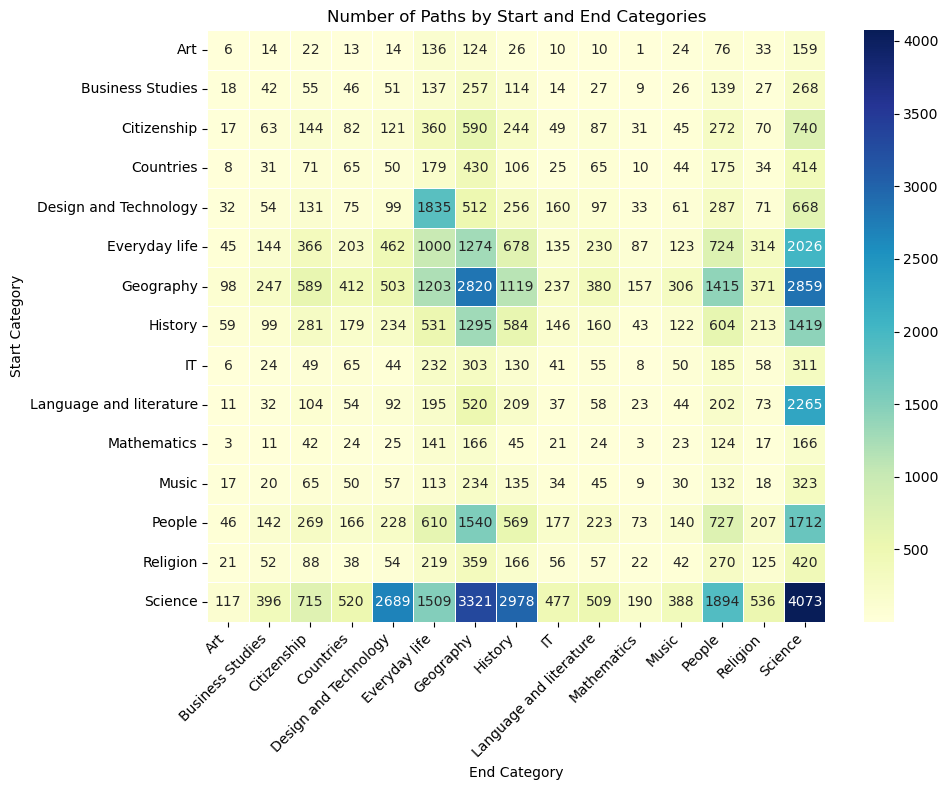

In [98]:
# Plot a heatmap of the category path counts
plt.figure(figsize=(10, 8))
sns.heatmap(category_path_counts, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title("Number of Paths by Start and End Categories")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

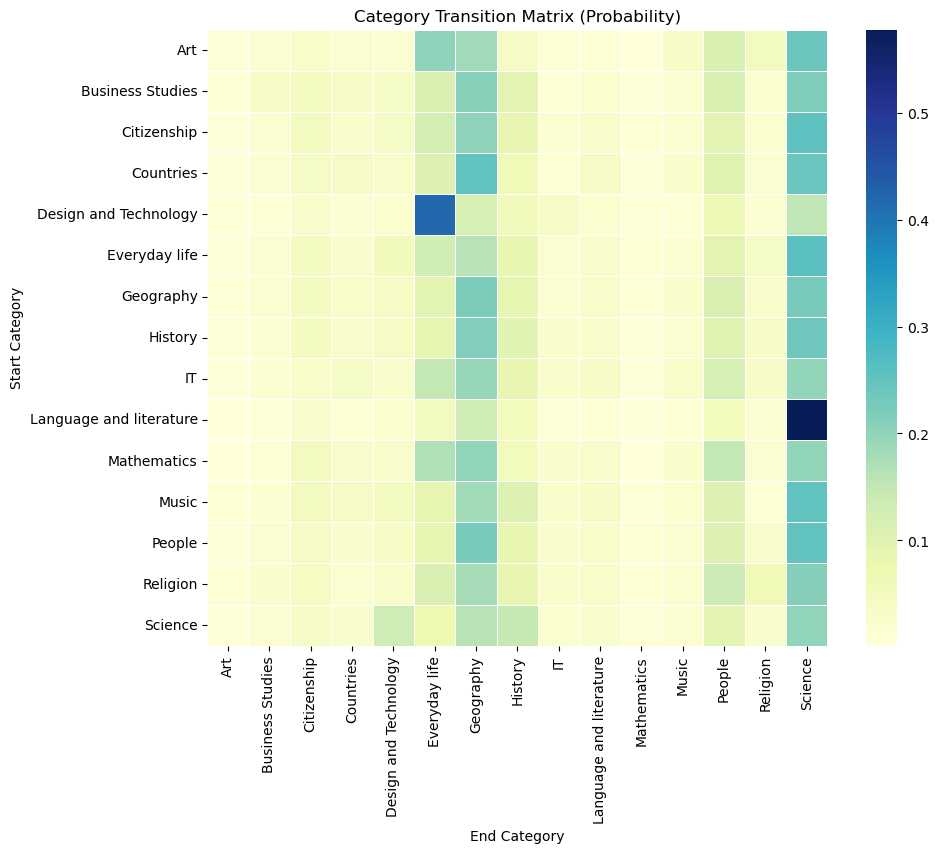

Top Category Flows:
              start_category           end_category  transition_count
224                  Science                Science              4073
216                  Science              Geography              3321
217                  Science                History              2978
104                Geography                Science              2859
96                 Geography              Geography              2820
214                  Science  Design and Technology              2689
149  Language and literature                Science              2265
89             Everyday life                Science              2026
222                  Science                 People              1894
65     Design and Technology          Everyday life              1835


In [ ]:
# Count the number of transitions from each start category to each end category
transition_counts = df_path.groupby(['start_category', 'end_category']).size().unstack(fill_value=0)

# Convert counts to probabilities (each row will sum to 1)
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)



plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title('Category Transition Matrix (Probability)')
plt.xlabel('End Category')
plt.ylabel('Start Category')
plt.show()



# Sum the transitions for each starting category to see the flow into each ending category
category_flow = df_path.groupby(['start_category', 'end_category']).size().reset_index(name='transition_count')

# Get the top N flows for better visualization (e.g., top 10)
top_flows = category_flow.sort_values(by='transition_count', ascending=False).head(10)


## danila general connectivity

# Narrative
Okay, now that we have introduced the dataset and the main research question, let's introduce the two main characters who will accompany us throughout this study: the tough student Pepito and his mentor, Mr. Cajal.

**Pepito**, a young neuroscience student in the class of the prestigious neuroscience class taught by none other than the esteemed **Dr. Ramón y Cajal**, recently found himself in an embarrassing situation.

Last week, Pepito participated in a popular online game known as Wikispeedia a challenge where players try to navigate from one Wikipedia page to a target page in the fewest possible clicks and in the shortest time. However, **Pepito’s performance was, to put it mildly, less than impressive**. He managed to complete only a few paths successfully, often getting lost in the sprawling web of hyperlinks.
When asked about his poor performance, Pepito felt he had no choice but to defend himself. He claimed that his **struggles in the game weren't due to a lack of academic ability, but rather to the game's inherent cognitive difficulty**. He argued that the game presented a high mental fatigue, requiring players to sift through a maze of potential paths across thousands of Wikipedia pages. According to Pepito, the game’s design itself made it easy for anyone, no matter how knowledgeable, to become disoriented. It is all about neuroscience!

Pepito, however, knew that he needed more than just verbal justification to defend his theory in front of Dr. Cajal. Recognizing the skepticism his claim might invite, **he resolved to back it up with solid data analysis**. His hope was to prove statistically that the game was challenging enough to lead even a skilled player into cognitive overload, validating his own struggles.

Dr. Cajal, familiar with Pepito’s poor academic record, was not entirely convinced by this argument. Dr. Cajal tried to refute the thesis of Pepito and he encouraged Pepito to a deeper engagement with his studies and his own academic potential.

What follows is a summary of the spirited discussion that took place between Pepito and Dr. Cajal, along with the data Pepito and Dr Cajal gathered and analyzed to make their cases. 

**Pepito’s research explores whether the cognitive fatigue involved in the Wikispeedia game is indeed as overwhelming as he claims or if, as Dr. Cajal suspects, no real influence is present.**


# Pepito Incipit: Humans are inefficient, but how much?

**Pepito**:

I begin my defense by arguing that humans are far from finding the optimal solution in a game of WikiSpeedia. Our brains, I believe, are inherently susceptible to cognitive biases that shape and influence our decision-making. To support my thesis, I point out that the average path length between two nodes in the network is much longer compared to the shortest path that can be determined using algorithms like Breadth-First Search (BFS). This inefficiency, in my view, reflects the limitations of human cognition—an inherent aspect of how our brains process information, which often leads us to make suboptimal choices.

In [170]:
# hsit FS Vs Huama with fidfee t path length



**Dr. Cajal**:

Your observation is valid, Pepito, but there are two important points to consider. First, the median path length in the human game is only one click longer than the median optimal solution, which suggests that humans are not as inefficient as you may think when playing the game. Second, while algorithms like BFS can search the entire network and determine the optimal path, humans do not have access to the full structure of the network. This limitation places humans at a significant disadvantage, as we are constrained by incomplete information during decision-making.

# Pepito's Simple Metal Fatigue Metrics

Please refer to [this notebook](src/notebooks/2_time_length.ipynb) for more details.

**Pepito:**

We all know that tasks that are repeated for long periods or become too complex can lead to confusion and, ultimately, cognitive fatigue. This is what I aim to demonstrate: that both the time taken to complete a path and the length of the path itself play a significant role in gameplay.

Since paths can either be completed or left unfinished, I base my argument on the assumption that unfinished paths are often a result of difficulty and the increased cognitive load experienced by the player during the process.

I will now show that these two factors—time and path length—are important indicators of cognitive strain in gameplay.

### Path Duration

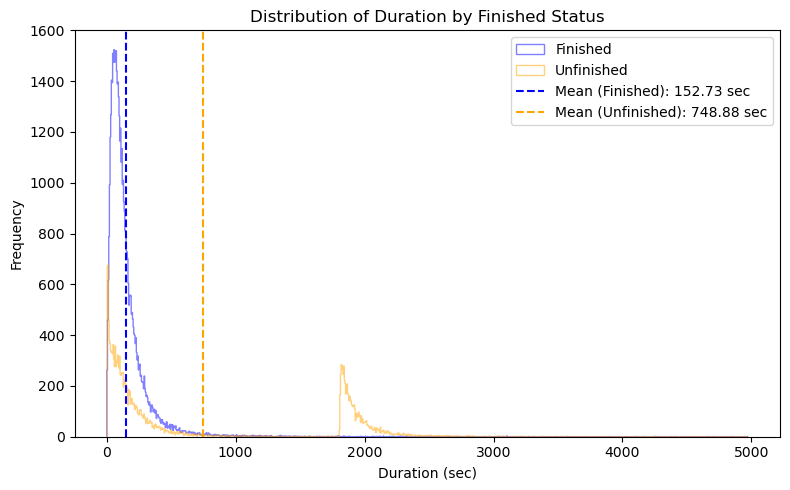

In [171]:
n_bins = 1000

# Separate data into finished and unfinished paths
finished_data = df_path[df_path["finished"] == True]["duration"]
unfinished_data = df_path[df_path["finished"] == False]["duration"]

# Plot the histogram: Duration by Finished Status
plt.figure(figsize=(8, 5))

# Plot the histogram for finished paths
plt.hist(finished_data, bins=n_bins, alpha=0.5, label='Finished', color='blue', histtype='step')

# Plot the histogram for unfinished paths
plt.hist(unfinished_data, bins=n_bins, alpha=0.5, label='Unfinished', color='orange', histtype='step')

# Calculate the mean durations
mean_duration_finished = finished_data.mean()
mean_duration_unfinished = unfinished_data.mean()

# Add vertical lines for the mean durations
plt.axvline(mean_duration_finished, color='blue', linestyle='--', label=f'Mean (Finished): {mean_duration_finished:.2f} sec')
plt.axvline(mean_duration_unfinished, color='orange', linestyle='--', label=f'Mean (Unfinished): {mean_duration_unfinished:.2f} sec')

# Add title, labels, and legend
plt.title("Distribution of Duration by Finished Status")
plt.xlabel("Duration (sec)")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

**Pepito:**
See, the mean duration of unfinished paths (orange line) is much higher compared to finished paths. This means time spent is a reliable predictor of the cognitive load on the person, and thus, the rate of abandonment.


**Dr. Cajal..**
Pepito, please!!! Don’t you see what a strange distribution you have? What about the tail for unfinished paths? Here, have a look. If I now take **only unfinished** paths and color them by the type of unfinished path, i.e., "abandonment" or "timeout," I can clearly see a distinct split. We cannot conclude that unfinished paths indicate higher cognitive load based solely on time spent.  

The increased mean duration in these cases is largely due to session timeouts. In these instances, players were not necessarily experiencing difficulty; rather, they abandoned the session, allowing time to accumulate passively. As a result, the prolonged durations in unfinished paths reflect a lapse in activity rather than active engagement or cognitive load. Thus, any assumptions about cognitive load based on these time differences would be unreliable.


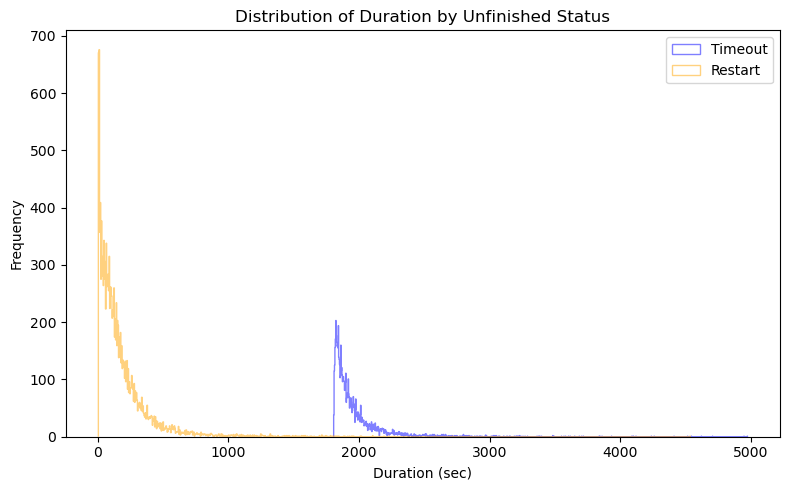

In [172]:
# Filter data for unfinished paths
unfinished_data = df_path[df_path["finished"] == False]

# Separate data into timeout and restart types
unfinished_data_timeout = unfinished_data[unfinished_data["type_unfinished"] == "timeout"]
unfinished_data_restart = unfinished_data[unfinished_data["type_unfinished"] == "restart"]

# Plot the histogram
plt.figure(figsize=(8, 5))

# Plot the histogram for timeout paths
plt.hist(unfinished_data_timeout["duration"], bins=n_bins, alpha=0.5, label='Timeout', color='blue', histtype='step')

# Plot the histogram for restart paths
plt.hist(unfinished_data_restart["duration"], bins=n_bins, alpha=0.5, label='Restart', color='orange', histtype='step')

# Add title, labels, and legend
plt.title("Distribution of Duration by Unfinished Status")
plt.xlabel("Duration (sec)")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Path Length
As the path length, and so cognitive struggle, does this influence the rate of abandonment?

### Mann-Whitney U Test

The **Mann-Whitney U test** is a non-parametric test used to compare the distributions of two independent groups. It is ideal when the data doesn't meet the normality assumption required for the t-test. Instead of comparing means, the test compares the ranks of values across both groups.

#### Why We Use It?
- **Non-Normal Data**: It doesn't assume normal distribution, making it suitable for skewed or non-normal data.
- **Distributions, Not Means**: It compares overall distributions, not just central tendencies like means.
- **When to Apply**: It's used when comparing two independent groups (e.g., finished vs. unfinished paths) to see if they have significantly different distributions.

#### Application:
We used the Mann-Whitney U test to compare the **path lengths** of finished and unfinished paths, testing if the distribution of lengths significantly differs between the two groups.


### Distribution of finish vs unfinished path

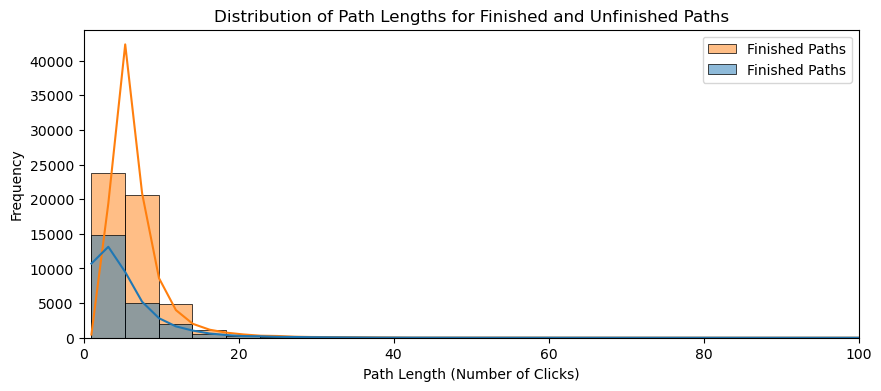

In [206]:
# Separate data into finished and unfinished paths
finished_paths = df_path[df_path['finished'] == True]
unfinished_paths = df_path[df_path['finished'] == False]

# Plot distribution of path lengths
plt.figure(figsize=(10, 4))
sns.histplot(df_path, x='n_click', hue='finished', kde=True, label='Finished Paths', bins=100)

#sns.histplot(finished_paths['n_click'], color='blue', kde=True, label='Finished Paths', bins=100)
#sns.histplot(unfinished_paths['n_click'], color='red', kde=True, label='Unfinished Paths', bins=100)
plt.title('Distribution of Path Lengths for Finished and Unfinished Paths')
plt.xlabel('Path Length (Number of Clicks)')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.legend()
plt.show()

In [156]:
# Separate data into finished and unfinished path lengths
finished_lengths = df_path[df_path['finished'] == True]['n_click']
unfinished_lengths = df_path[df_path['finished'] == False]['n_click']

# Perform Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(finished_lengths, unfinished_lengths)
print(f"Mann-Whitney U test results for Finished vs. Unfinished Path Lengths: U = {u_stat}, p-value = {p_value}")


Mann-Whitney U test results for Finished vs. Unfinished Path Lengths: U = 772366749.0, p-value = 0.0


### Conclusion

The Mann-Whitney U test reveals a significant difference in path lengths between finished and unfinished paths, with a p-value of effectively 0. This suggests that the distribution of path lengths varies depending on whether a path is completed or abandoned.



### Statistical analysis between finished and unfinished paths.

Finished Path Statistics:
Mean: 6.758385335413417, Median: 6.0, Std: 4.680948345149986, IQR: 3.0

Unfinished Path Statistics:
Mean: 5.539502496277481, Median: 4.0, Std: 5.498529119931578, IQR: 5.0


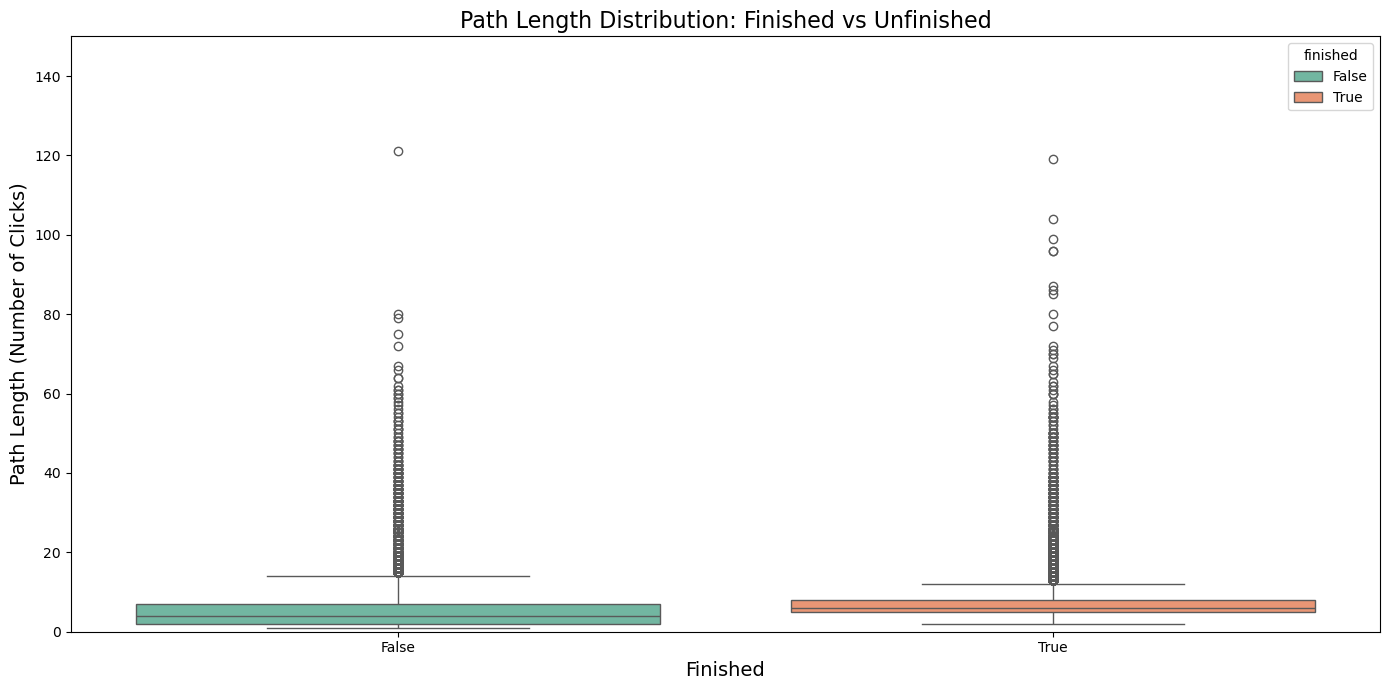

In [229]:
# Split data into finished and unfinished paths
finished_paths = df_path[df_path['finished'] == True]
unfinished_paths = df_path[df_path['finished'] == False]

# Descriptive statistics for finished paths
finished_stats = finished_paths['n_click'].describe()
unfinished_stats = unfinished_paths['n_click'].describe()

# Mean, median, standard deviation for both categories
finished_mean = finished_paths['n_click'].mean()
unfinished_mean = unfinished_paths['n_click'].mean()

finished_median = finished_paths['n_click'].median()
unfinished_median = unfinished_paths['n_click'].median()

finished_std = finished_paths['n_click'].std()
unfinished_std = unfinished_paths['n_click'].std()

finished_iqr = finished_paths['n_click'].quantile(0.75) - finished_paths['n_click'].quantile(0.25)
unfinished_iqr = unfinished_paths['n_click'].quantile(0.75) - unfinished_paths['n_click'].quantile(0.25)

# Print statistics
print("Finished Path Statistics:")
print(f"Mean: {finished_mean}, Median: {finished_median}, Std: {finished_std}, IQR: {finished_iqr}")
print("\nUnfinished Path Statistics:")
print(f"Mean: {unfinished_mean}, Median: {unfinished_median}, Std: {unfinished_std}, IQR: {unfinished_iqr}")

# Plot distribution of path lengths for both finished and unfinished paths
plt.figure(figsize=(14, 7))

# Boxplot for finished and unfinished paths, with hue as 'finished'
sns.boxplot(x='finished', y='n_click', data=df_path, palette='Set2', showfliers=True, hue='finished')

# Add a title and labels
plt.title('Path Length Distribution: Finished vs Unfinished', fontsize=16)
plt.xlabel('Finished', fontsize=14)
plt.ylabel('Path Length (Number of Clicks)', fontsize=14)

# Set consistent y-axis limits
plt.ylim(0, 150)

# Show the plot
plt.tight_layout()
plt.show()

### Conclusion

The analysis of path lengths for finished and unfinished paths reveals some interesting trends. Finished paths tend to be slightly longer on average (mean of 6.76 clicks) and more consistent in length, with a smaller IQR of 3. This suggests that users who complete paths tend to follow relatively similar journeys.

In contrast, unfinished paths have a slightly shorter average length (mean of 5.54 clicks) but show more variability (IQR of 5). This indicates that users abandon paths at various stages, with some quitting early and others abandoning after a longer path. The higher standard deviation and IQR for unfinished paths suggest greater diversity in user behavior when it comes to abandonment.

Overall, it appears that users tend to complete paths that are moderately long and consistent, while abandonment tends to happen earlier and with more variability in path lengths.


## Role of Speed

### We will analyze how the time per click evolve with the path length

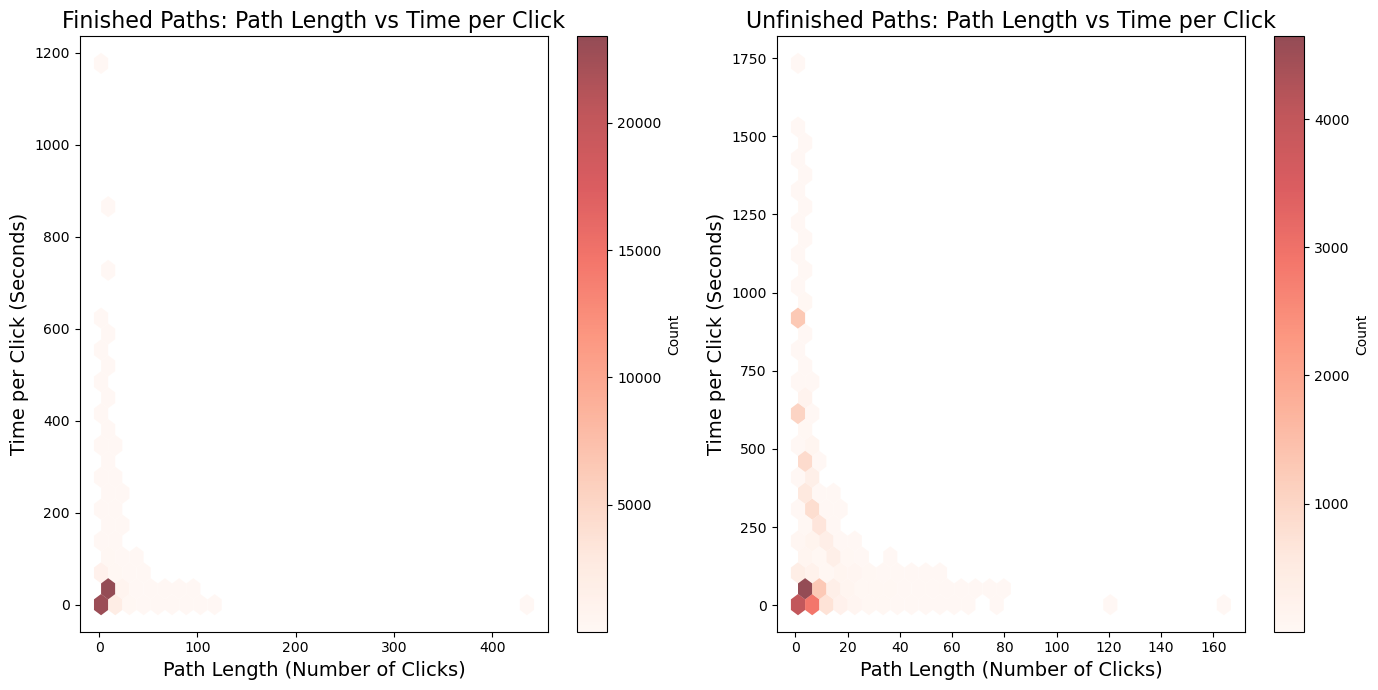

In [218]:
# Calculate speed (time per click) for each path
df_path['time_per_click'] = df_path['duration'] / df_path['n_click']

# Separate data for finished and unfinished paths
finished_paths = df_path[df_path['finished'] == True]
unfinished_paths = df_path[df_path['finished'] == False]

# Set up the figure size
plt.figure(figsize=(14, 7))

# Hexbin plot for Finished Paths
plt.subplot(1, 2, 1)  
plt.hexbin(finished_paths['n_click'], finished_paths['time_per_click'], gridsize=30, cmap='Reds', mincnt=1, edgecolors='none', alpha=0.7)
plt.colorbar(label='Count')
plt.title('Finished Paths: Path Length vs Time per Click', fontsize=16)
plt.xlabel('Path Length (Number of Clicks)', fontsize=14)
plt.ylabel('Time per Click (Seconds)', fontsize=14)

# Hexbin plot for Unfinished Paths
plt.subplot(1, 2, 2)  
plt.hexbin(unfinished_paths['n_click'], unfinished_paths['time_per_click'], gridsize=30, cmap='Reds', mincnt=1, edgecolors='none', alpha=0.7)
plt.colorbar(label='Count')
plt.title('Unfinished Paths: Path Length vs Time per Click', fontsize=16)
plt.xlabel('Path Length (Number of Clicks)', fontsize=14)
plt.ylabel('Time per Click (Seconds)', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [219]:
# Define short and long paths based on click count
short_paths = df_path[df_path['n_click'] <= 10]['normalized_duration']
long_paths = df_path[df_path['n_click'] > 10]['normalized_duration']

# Perform Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(short_paths, long_paths)
print(f"Mann-Whitney U test results: U = {u_stat}, p-value = {p_value}")

Mann-Whitney U test results: U = 228127950.5, p-value = 2.4294561434521484e-63


### Mann-Whitney U Test Analysis

We conducted a Mann-Whitney U test to evaluate if there is a statistically significant difference in the normalized duration (time per click) between short paths (10 clicks or fewer) and long paths (more than 10 clicks). The results were as follows:

- **U statistic**: 228,127,950.5
- **p-value**: 2.43e-63

Given the extremely low p-value, we can conclude that there is a statistically significant difference in the time per click between short and long paths. This finding suggests that as paths get longer, users tend to spend different amounts of time per click, potentially indicating changes in cognitive load or engagement. Longer paths might involve more complex or challenging navigation, requiring users to spend more time deciding on each step.


1. **Faster Clicking on Longer Paths**: As paths get longer, users tend to click faster, possibly trying to complete the game quickly.

2. **Slow Navigation on Short Paths**: Shorter paths, especially unfinished ones, show longer time per click, suggesting users take more time at the start, perhaps due to unfamiliarity or exploration.

3. **Struggle and Abandonment**: Slower clicking is more common in unfinished paths, indicating that when users take more time per click, they may be struggling, leading to a higher chance of abandoning the path.


# Pepito and Readability Metrics

Please refer to [this notebook](src/notebooks/3_readability.ipynb) for more details.

**Pepito:**  
WikiSpeedia is a game based on articles, specifically written text. Whether the user is willing or unwilling, they are constantly interacting with phrases and sentences. Previous studies have shown that complex text can lead to mental fatigue, and readability metrics—such as those used to assess the ease of reading—can serve as a proxy to quantify this aspect[Readability Measures as Predictors of Understandability and Engagement in Searching to Learn](https://typeset.io/papers/readability-measures-as-predictors-of-understandability-and-4cc738phts).


Before proceing with the analysis we must define what are readability metrics, and which one we are goin to use:

**Readability metrics measure the ease with which a reader can understand a text.** Factors such as sentence length, word complexity, and the use of jargon all contribute to these measurements. 

<span style="font-size:28px">Flesch-Kincaid Grade Level:</span>
$$
0.39 \times \left(\frac{\text{total words}}{\text{total sentences}}\right) + 11.8 \times \left(\frac{\text{total syllables}}{\text{total words}}\right) - 15.59
$$

<span style="font-size:28px">Gunning Fog Index:</span>
$$
0.4 \times \left( \left( \frac{\text{total words}}{\text{total sentences}} \right) + \frac{\text{complex words}}{\text{total words}} \times 100 \right)
$$

<span style="font-size:28px">Automated Readability Index (ARI):</span>
$$
4.71 \times \left(\frac{\text{total characters}}{\text{total words}}\right) + 0.5 \times \left(\frac{\text{total words}}{\text{total sentences}}\right) - 21.43
$$

<span style="font-size:28px">SMOG (Simple Measure of Gobbledygook):</span>
$$
1.0430 \times \sqrt{\text{polysyllabic words} \times \left( \frac{30}{\text{total sentences}} \right)} + 3.1291
$$

<span style="font-size:28px">Coleman-Liau Index:</span>
$$
0.0588 \times \left( \frac{\text{total characters}}{\text{total words}} \times 100 \right) - 0.296 \times \left( \frac{\text{total sentences}}{\text{total words}} \times 100 \right) - 15.8
$$

<span style="font-size:28px">Readability Consensus Index:</span>
   - **What it measures:** This combines several readability formulas (like Flesch-Kincaid, Gunning Fog, ARI) into a single score that estimates the overall readability of the text.
   - **How to calculate:** Average the results of different readability formulas to obtain a comprehensive view of the text's accessibility.




In [174]:
df_fatigue = pd.read_csv("data/output/fatigue_metric_data/articles_fatigues_long.csv")

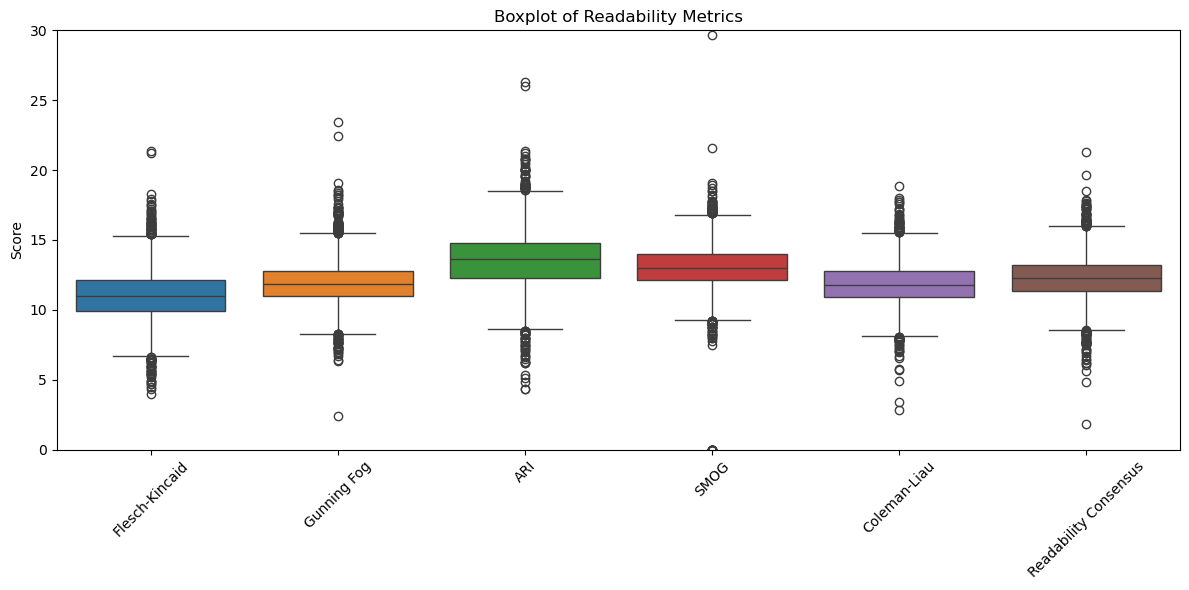

In [175]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Boxplot for readability metrics
sns.boxplot(data=df_fatigue[['Flesch-Kincaid', 'Gunning Fog', 'ARI', 'SMOG', 'Coleman-Liau', 'Readability Consensus']])
plt.title('Boxplot of Readability Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 30)

# Show the plot
plt.tight_layout()
plt.show()


**Pepito:**
As all the Metrics seems to have the same distribution, I will use mainly the `Readability Consensus` as it is a good middle way between them.

In [176]:
# Calculate aggregate metrics
aggregate_metrics = df_fatigue[['Flesch-Kincaid', 'Gunning Fog', 'ARI', 'SMOG', 'Coleman-Liau', 'Readability Consensus']].agg(['mean', 'median', 'std', 'min', 'max'])

# Display the aggregate metrics
display(aggregate_metrics)

,Flesch-Kincaid,Gunning Fog,ARI,SMOG,Coleman-Liau,Readability Consensus
mean,11.063054,11.911123,13.585404,12.974761,11.823812,12.271631
median,11.000000,11.830000,13.600000,13.000000,11.780000,12.266000
std,1.852231,1.577178,2.131589,1.814130,1.473235,1.593012
min,-0.400000,2.400000,4.300000,0.000000,2.830000,1.826000
max,45.900000,42.830000,59.900000,29.700000,18.880000,39.442000


### Mean Readability per Path

Naturally, Pepito wanted to calculate a more reliable metric for each path, rather than just for individual articles. To do this, he created an overall readability metric by averaging the scores of the readability metrics for each article that made up a given path. (A detailed procedure on how to create the corresponding dataset is reported in the previously cited notebook.)

In [177]:
df_path_fatigue = pd.read_csv("data/output/fatigue_metric_data/path_processed_with_readability.csv",low_memory=False)

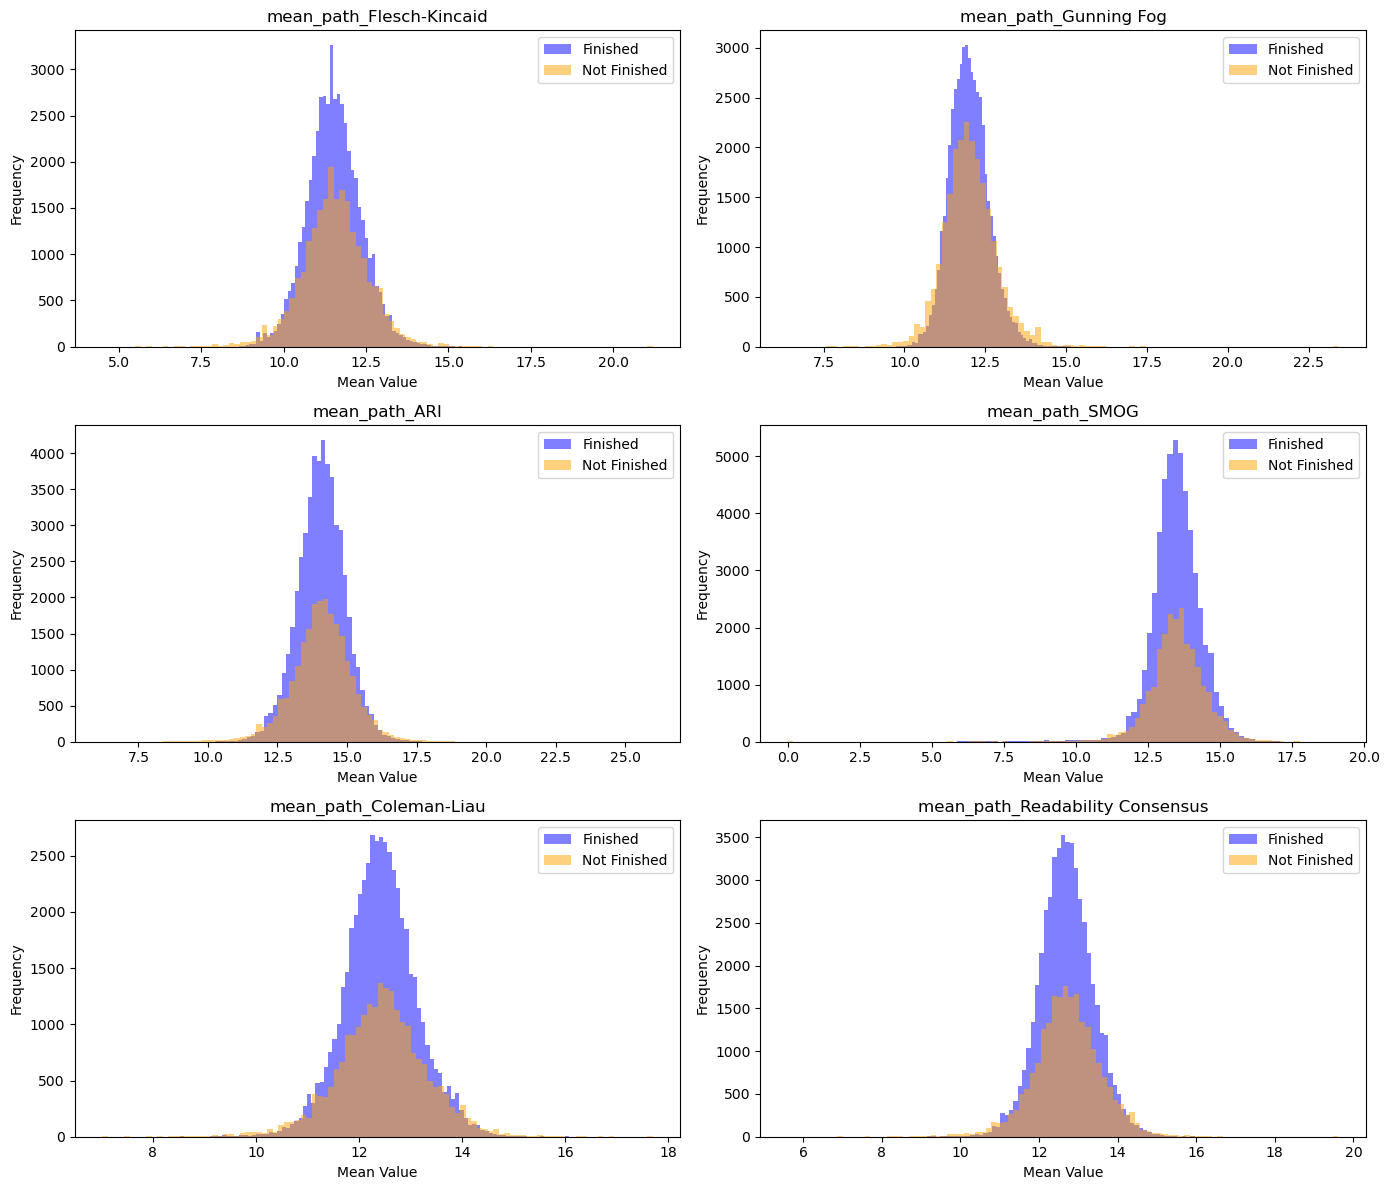

In [178]:
# Set up the figure and axes for the histograms
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# List of metrics to plot
metrics = [
    'mean_path_Flesch-Kincaid',
    'mean_path_Gunning Fog',
    'mean_path_ARI',
    'mean_path_SMOG',
    'mean_path_Coleman-Liau',
    'mean_path_Readability Consensus'
]

# Plot histograms for each metric, split by finished status
for i, metric in enumerate(metrics):
    # Plot for finished == True
    axes[i].hist(df_path_fatigue[df_path_fatigue['finished'] == True][metric], 
                  alpha=0.5, label='Finished', color='blue', bins=100)
    # Plot for finished == False
    axes[i].hist(df_path_fatigue[df_path_fatigue['finished'] == False][metric], 
                  alpha=0.5, label='Not Finished', color='orange', bins=100)
    
    # Labeling
    axes[i].set_title(metric)
    axes[i].set_xlabel('Mean Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Even though the distribution between finished and unfinished paths seems quite similar, Pepito refuses to give up and wants to perform a t-test to be absolutely sure that there is no significant difference between the two.

**What is a t-test?**
A t-test is a statistical test used to compare the means of two groups to determine if there is a significant difference between them. It helps assess whether the observed differences are due to chance or represent a true effect.

**Assumptions of a t-test**
The t-test assumes that the samples from each group are independent of each other, that the data in each group are approximately normally distributed, and (in the case of a two-sample t-test) that the variances of the two groups are roughly equal.

In [179]:
# Store results
results = {}

metrics = [
    'mean_path_Flesch-Kincaid',
    'mean_path_Gunning Fog',
    'mean_path_ARI',
    'mean_path_SMOG',
    'mean_path_Coleman-Liau',
    'mean_path_Readability Consensus'
]

# Perform t-tests for each metric
for metric in metrics:
    finished_data = df_path_fatigue[df_path_fatigue['finished'] == True][metric]
    not_finished_data = df_path_fatigue[df_path_fatigue['finished'] == False][metric]
    
    t_stat, p_value = stats.ttest_ind(finished_data, not_finished_data, equal_var=False)  # Welch's t-test
    results[metric] = {'t_statistic': t_stat, 'p_value': p_value}

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).T
results_df['significant'] = results_df['p_value'] < 0.05  # Determine significance

# Display results
print(results_df)

                                 t_statistic   p_value  significant
mean_path_Flesch-Kincaid           -1.697088  0.089689        False
mean_path_Gunning Fog              -4.696039  0.000003         True
mean_path_ARI                      -1.698978  0.089332        False
mean_path_SMOG                     -0.848272  0.396292        False
mean_path_Coleman-Liau             -1.435003  0.151295        False
mean_path_Readability Consensus    -2.181674  0.029140         True


**Pepito:**
See, it's clear—there is a statistically significant difference in the means of finished and unfinished paths for the Readability Consensus. This clearly shows that readability plays a role in the gameplay of WikiSpeedia.

In [180]:
grouped_means = df_path_fatigue.groupby('finished')['mean_path_Readability Consensus'].mean()
grouped_means

finished
False    12.715505
True     12.700971
Name: mean_path_Readability Consensus, dtype: float64

**Cajal:**

First of all, you did not show that there is a significant difference for any of the individual metrics. Furthermore, you need to understand the **difference between statistical significance and practical significance.**

Statistical significance means that the difference you observed is unlikely to have happened by chance, usually indicated by a p-value less than 0.05. However, practical significance concerns whether this difference is large enough to have a real-world impact. A statistically significant result does not necessarily mean it is meaningful in the context of the game.

Even though your findings might be statistically significant (with a p-value < 0.05), the actual change in means is so small (~0.01) that it would not affect gameplay in any meaningful way. Therefore, these results cannot be used to support your theory, Pepito.

***

# Cajal's Response: Entropy

Dr. Cajal is growing increasingly frustrated with the weak thesis presented by Pepito and decides to counterattack with a more powerful concept: **Entropy**.

**Dr. Cajal:**

"Dear Pepito, let's examine a more complex metric—the entropy of a path. Entropy, you could say, serves **as an index of indecisiveness and uncertainty**. It helps us understand why some paths are abandoned mid-journey. High entropy suggests that users are navigating across many different articles without a clear direction, likely due to cognitive overload or confusion. In essence, entropy quantifies decision-making uncertainty and can act as a proxy for cognitive load, revealing the challenges that players face as they attempt to complete paths.
If this theory holds—if entropy indeed impacts gameplay—then we should observe higher average entropy per path in unfinished journeys compared to completed ones. **I will show you that this is not the case.**"

Before we proceed, let’s define the metrics we’ll be using in detail:

### Article Entropy
**Shannon Entropy**: When an article leads to multiple different subsequent articles with similar probabilities, its entropy will be high. Formally, we define entropy for **a single article** as:

\[
H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)
\]

Where:
- **H(X)** represents the Shannon entropy of the random variable **X**.
- **p(x_i)** is the probability of each possible outcome **x_i** (e.g., the probability of transitioning to a specific subsequent article).
- **n** is the total number of possible outcomes (next articles).

### Path Entropy
**Path Entropy** is the mean entropy of the articles within a path. 


In [181]:
# As usual we are going to only load the pre-conputed data
# For specific pipeline please refer to the relative notebook

entropy_path = pd.read_csv("data/output/entropy_data/entropy_per_path.csv", low_memory=False)
entropy_article = pd.read_csv("data/output/entropy_data/entropy_per_article.csv")
entropy_adj = pd.read_csv("data/output/entropy_data/entropy_adj.csv")
entropy_adj = entropy_adj.set_index("article_name")

**Dr. Cajal:**

Let's make an example. As you can see the Entropy of *Dante Alighieri* is relatively high, due to the relative multiples path that gamers have taken during the past games.

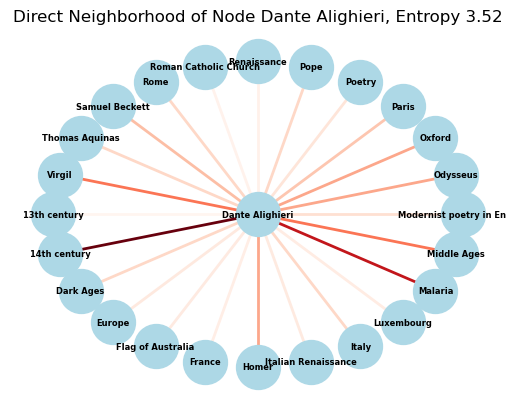

In [182]:
# Select the specific node for which you want to draw its neighborhood
node_of_interest = "Dante Alighieri"  # Replace with the actual node label

# Create the graph from the adjacency matrix
G = nx.from_pandas_adjacency(entropy_adj)

# Get only the edges directly connected to the node_of_interest
ego_edges = [(node_of_interest, neighbor) for neighbor in G.neighbors(node_of_interest)]
ego_subgraph = G.edge_subgraph(ego_edges)  # Create a subgraph with only those edges

# Define positions for the nodes in a star layout (circular around the core)
pos = nx.shell_layout(ego_subgraph, nlist=[[node_of_interest], list(G.neighbors(node_of_interest))])

# Get edge weights and map them to colors on a heatmap
edge_weights = np.array([G.edges[edge]['weight'] for edge in ego_edges])
norm = plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max())  # Normalize weights for color mapping
edge_colors = [cm.Reds(norm(weight)) for weight in edge_weights]  # Map weights to colors using colormap

# Draw the subgraph with scaled edge colors based on weights
fig, ax = plt.subplots()
fig.patch.set_facecolor('black')  # Set the background color of the entire figure to black
ax.set_facecolor('black')  # Set the plot area background to black

nx.draw(
    ego_subgraph,
    pos,
    with_labels=True,
    node_size=1000,
    node_color='lightblue',
    font_size=6,
    font_weight='bold',
    edge_color=edge_colors,  # Use color map for edge colors
    width=2,  # Set a fixed width for better visibility
    ax=ax     # Draw on the specified axis
)

# Set the title with white font color for visibility on black background
plt.title(f'Direct Neighborhood of Node {node_of_interest}, Entropy {entropy_article[entropy_article["article_name"] == node_of_interest]["entropy"].values[0]:.2f}', color='black')
plt.show()


**Dr. Cajal:***

Firslty observe that there is almost no correlation between unfinished and the mean entropy per path, signifing no relationship between the two.

We are going ot use the metric: **Point-Biserial Correlation** which measures the strength and direction of the relationship between a binary categorical variable and a continuous variable. It is a special case of the Pearson correlation when one variable is binary (0 or 1) and the other is continuous.
$$
r_{pb} = \frac{M_1 - M_0}{s} \cdot \sqrt{\frac{n_1 n_0}{n(n - 1)}}
$$

Where:
- \( M_1 \) = mean of the continuous variable for the group with label 1
- \( M_0 \) = mean of the continuous variable for the group with label 0
- \( s \) = standard deviation of the continuous variable
- \( n_1 \) = number of observations with label 1
- \( n_0 \) = number of observations with label 0
- \( n \) = total number of observations



In [183]:
# Assuming `category` is binary (0/1) and `continuous_var` is the continuous variable
correlation, p_value = pointbiserialr(entropy_path["finished"], entropy_path["entropy_path"])
print(f"Point-Biserial Correlation: {correlation}, p-value: {p_value}")


Point-Biserial Correlation: 0.19409625942219275, p-value: 0.0


**Dr. Cajal:***

Secondly, it is important to note that there is a significant difference in the means of finished and unfinished paths (calculated using a t-test), but interestingly, this difference favors the unfinished paths. Therefore, your hypothesis that higher entropy is associated with abandonment is not only incorrect, but actually completely reversed. People who succeed tend to follow paths with higher entropy. In essence, they are seeking complexity.

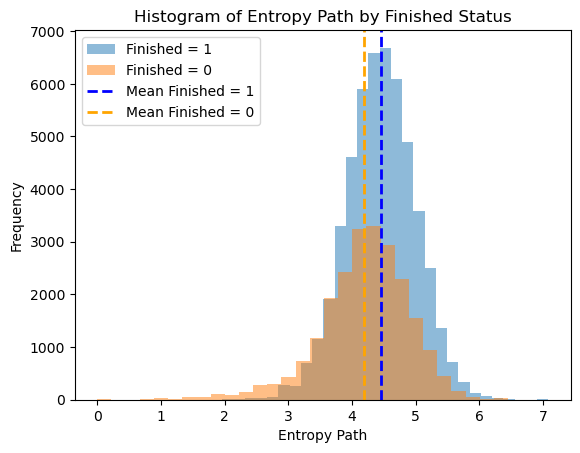

In [184]:
# Calculate means for both finished categories
mean_finished_1 = entropy_path[entropy_path['finished'] == 1]['entropy_path'].mean()
mean_finished_0 = entropy_path[entropy_path['finished'] == 0]['entropy_path'].mean()

# Create the plot
fig, ax = plt.subplots()

# Plot histograms for both categories
ax.hist(entropy_path[entropy_path['finished'] == 1]['entropy_path'].dropna(), bins=30, alpha=0.5, label='Finished = 1')
ax.hist(entropy_path[entropy_path['finished'] == 0]['entropy_path'].dropna(), bins=30, alpha=0.5, label='Finished = 0')

# Plot vertical lines for the means
ax.axvline(mean_finished_1, color='blue', linestyle='dashed', linewidth=2, label='Mean Finished = 1')
ax.axvline(mean_finished_0, color='orange', linestyle='dashed', linewidth=2, label='Mean Finished = 0')

# Set plot title and labels
ax.set_title('Histogram of Entropy Path by Finished Status')
ax.set_xlabel('Entropy Path')
ax.set_ylabel('Frequency')

# Display the legend
ax.legend()

# Show the plot
plt.show()

In [185]:
# Separate the groups based on the 'finished' column
group1 = entropy_path[entropy_path['finished'] == 1]['entropy_path'].dropna()  # Group where finished = 1
group2 = entropy_path[entropy_path['finished'] == 0]['entropy_path'].dropna()  # Group where finished = 0

# Perform an independent t-test
# ATTENTION: from the hist of above the data seems gaussian
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)  # Use equal_var=False for Welch's t-test

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The means are significantly different.")
else:
    print("Fail to reject the null hypothesis: The means are not significantly different.")

T-statistic: 53.86419551049631
P-value: 0.0
Reject the null hypothesis: The means are significantly different.


**Pepito:**

Your analysis is correct, but it doesn’t quite make sense to me. Based on your findings, it seems that people are intentionally seeking out articles with higher entropy, almost as if they enjoy engaging with more chaotic content. This is a very strange behavior, and I would appreciate it if you could explain why this happens. At this moment, I remain skeptical about your conclusion.

# Dr. Cajal Clarifies Pepito's Concerns: Connectivity Analysis

In [186]:
#answer entropy

#recall EDA connecotvt

# show that articles with high entirpy are also high connected

conelcusion: ...

In [187]:
# shor that ueint the "mission" gamer go beofre to hgi connectovy hubs

# grpah on gogole doc

cluclsion: 
- epxlain conseuquncies
- fuejtnher show tha entory is wrng

# Cognitive shift

Moving from one category of knowledge to another (e.g., from science-related articles to arts-related articles) requires cognitive shifting, which can increase cognitive load. Cognitive shifting is known to engage the executive function of the brain and may lead to errors or abandonment if the shift is too taxing

In [188]:
df_cognitive_shift = pd.read_csv("data/output/cognitive_shift_data/paths_cognitive_shift.csv", low_memory=False)

cols_to_convert = ["path_semantic_shift", "path_similarity"]

for col in cols_to_convert:
    df_cognitive_shift[col] = df_cognitive_shift[col].apply(ast.literal_eval)

## Shift per Category

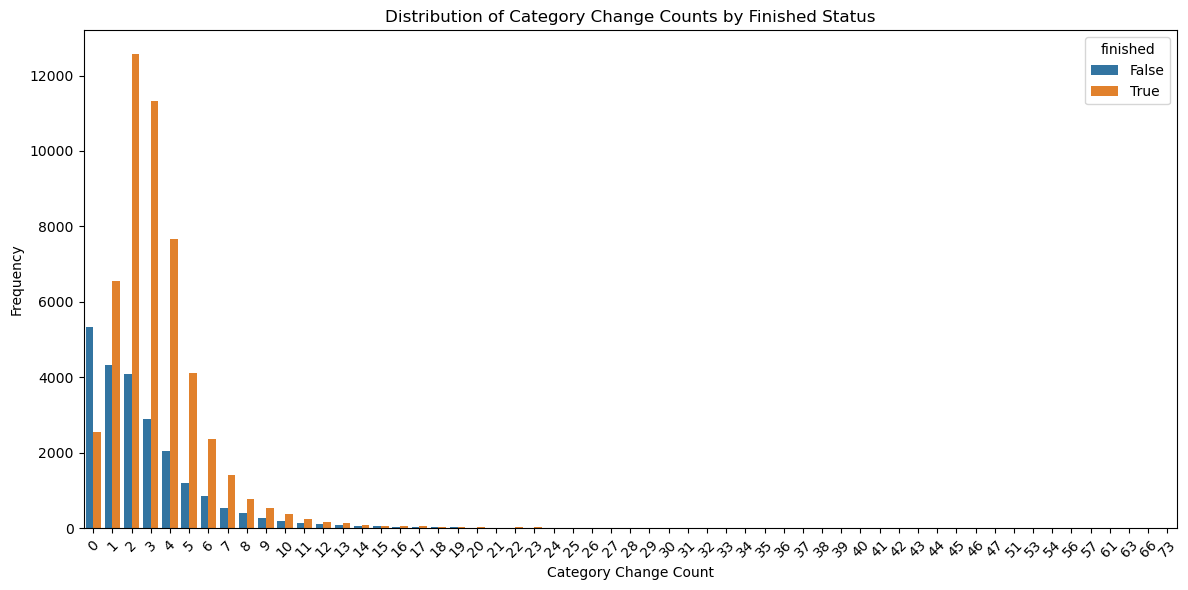

In [189]:
# Step 2: Aggregate the data
# Group by 'finished' and 'category_change_count' to count occurrences
agg_data = df_cognitive_shift.groupby(['finished', 'category_change_count']).size().reset_index(name='count')

# Step 3: Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_data, x='category_change_count', y='count', hue='finished')#, palette={True: "green", False: "red"})

# Step 4: Customize the plot
plt.title("Distribution of Category Change Counts by Finished Status")
plt.xlabel("Category Change Count")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()

In [190]:
finished_counts = df_cognitive_shift[df_cognitive_shift["finished"] == True]["category_change_count"]
not_finished_counts = df_cognitive_shift[df_cognitive_shift["finished"] == False]["category_change_count"]

t_stat, p_value = stats.ttest_ind(finished_counts, not_finished_counts, equal_var=False)  # Use Welch's t-test

alpha = 0.05  # Significance level
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two groups.")

T-statistic: 23.506
P-value: 0.000
Reject the null hypothesis: There is a significant difference between the means of the two groups.


### Conclusion

Unexpectedly, the significant shift per link is higher in finished paths, which challenges our initial assumption that a higher shift would correlate with increased cognitive load and greater difficulty. This finding suggests that the relationship between cognitive load and task completion is more complex than anticipated. (Pepito is totally wrong).

To continue on the analysis of cognitive shifting, we will try a different more specific, semantic similarity.

## Semantic similarity shift

Instead of looking at the shift in article category, we will try looking at the semantic shift between articles. This is calculated by taking the 1 minus the semantic similarity between two successive articles, thus giving us the semantic difference between the two articles. Large semantic shifts between articles can represent a higher cognitive load for the player, having to completely change topics from one article to the other. We will try to analyse this semantic shift along paths to see if this can have an impact on whether the path is finished or not.

We will use SentenceTransmormer, which embeds text to multidimensional vectors that can then be compared by taking the "angle" between two vectors.

This is an example to show the semantic similarity at work. The results obtained are about what we would expect, William Shakespeare being semantically close to playwright and Romeo and Juliet, but having nothing to do with Data analysis. This isn't perfect as it struggles with more complex relationships such as between "Romeo and Juliet" and "love" which one could expect to be closely related.

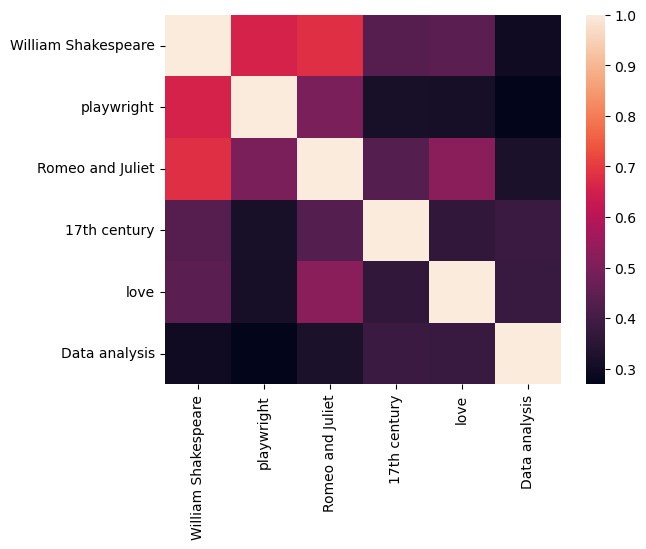

In [191]:
df_example_similarity = pd.read_csv("data/output/cognitive_shift_data/example_similarity.csv", index_col=0)

sns.heatmap(df_example_similarity)
plt.show()

Semantic shift (finished paths): mean = 0.5030 median = 0.5040
Semantic shift (unfinished paths): mean = 0.5171 median = 0.5179
P-value = 8.465336706719095e-97 so the semantic shift between finished and unfinished paths is statistically different


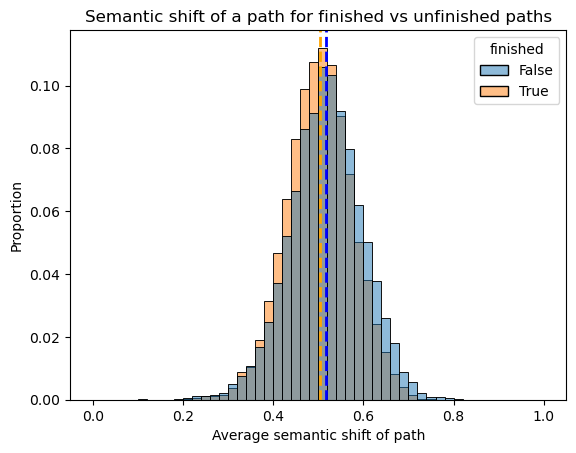

In [192]:
# get all semantic shifts in lists
mean_semantic_shift_pf = df_cognitive_shift[df_cognitive_shift["finished"] == True]["average_semantic_shift"]
mean_semantic_shift_pf = [x for x in mean_semantic_shift_pf if ~np.isnan(x)]

mean_semantic_shift_uf = df_cognitive_shift[df_cognitive_shift["finished"] == False]["average_semantic_shift"]
mean_semantic_shift_uf = [x for x in mean_semantic_shift_uf if ~np.isnan(x)]

print(f"Semantic shift (finished paths): mean = {np.mean(mean_semantic_shift_pf):.4f} median = {np.median(mean_semantic_shift_pf):.4f}")
print(f"Semantic shift (unfinished paths): mean = {np.mean(mean_semantic_shift_uf):.4f} median = {np.median(mean_semantic_shift_uf):.4f}")
pval = stats.ttest_ind(mean_semantic_shift_pf, mean_semantic_shift_uf).pvalue
print("P-value = {} so the semantic shift between finished and unfinished paths is statistically different".format(pval))

sns.histplot(data=df_cognitive_shift, x="average_semantic_shift", hue="finished", multiple="layer", binwidth=0.02, binrange=[0,1], stat="proportion", common_norm = False, alpha=0.5)
plt.title("Semantic shift of a path for finished vs unfinished paths")
plt.xlabel("Average semantic shift of path")
plt.axvline(np.mean(mean_semantic_shift_pf), color='orange', linestyle='dashed', linewidth=2, label='Mean Finished')
plt.axvline(np.mean(mean_semantic_shift_uf), color='blue', linestyle='dashed', linewidth=2, label='Mean Unfinished')
plt.show()

We can see that semantic shift along finished paths is smaller than for unfinished paths, which means finished paths tend to follow more closely related articles than unfinished paths. The difference is small, as seen by the overall means being close, but still statiscally significant.

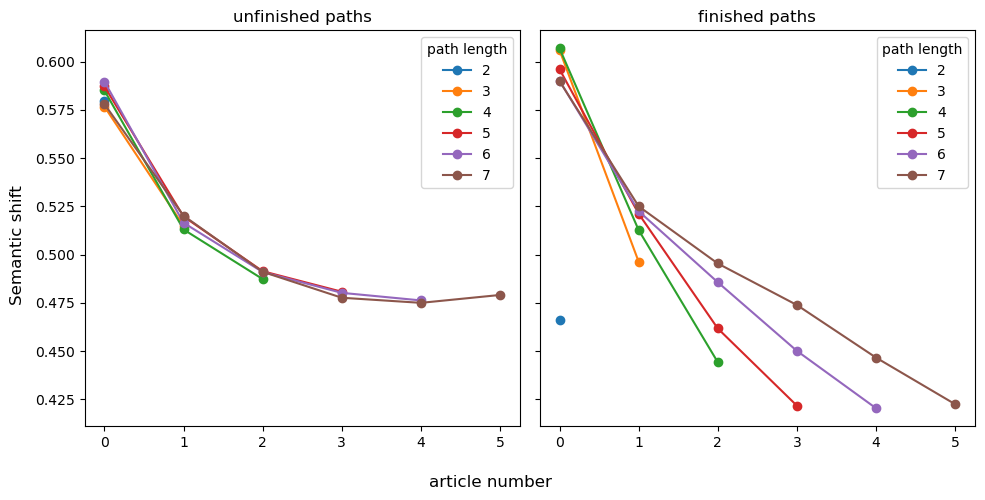

In [193]:
# min/max lengths of paths to include
min_length = 2
max_length = 7

# dfs to store the semantic shifts for each path length
df_uf_shift = pd.DataFrame(index = [x for x in range (min_length, max_length + 1)], columns = [x for x in range (0, max_length)])
df_pf_shift = pd.DataFrame(index = [x for x in range (min_length, max_length + 1)], columns = [x for x in range (0, max_length)])

for length in range (min_length, max_length + 1):
    # get the semantic shift of paths of correct length
    shifts = df_cognitive_shift.loc[(df_cognitive_shift["finished"] == False) & (df_cognitive_shift["n_click"] == length)]["path_semantic_shift"].tolist()
    # compute mean semantic shift for each article position
    shifts = np.nanmean(np.array(shifts), axis=0).tolist()
    # complete with nans to add to df
    shifts += [np.nan] * (max_length + 1 - length)
    df_uf_shift.iloc[length - min_length] = shifts

    shifts = df_cognitive_shift.loc[(df_cognitive_shift["finished"] == True) & (df_cognitive_shift["n_click"] == length)]["path_semantic_shift"].tolist()
    shifts = np.nanmean(np.array(shifts), axis=0).tolist()
    shifts += [np.nan] * (max_length + 1 - length)
    df_pf_shift.iloc[length - min_length] = shifts

# display semantic shifts

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.supxlabel("article number")
fig.supylabel("Semantic shift")

x = [x for x in range (max_length)]
len_path = min_length
for it, row in df_uf_shift.iterrows():
    axs[0].plot(x, row, marker = "o", label = len_path)
    axs[0].set_title("unfinished paths")
    axs[0].legend(title="path length", loc = "upper right")
    axs[0].xaxis.set_major_locator(plt.MultipleLocator(1))
    len_path += 1

len_path = min_length
for it, row in df_pf_shift.iterrows():
    axs[1].plot(x, row, marker = "o", label = len_path)
    axs[1].set_title("finished paths")
    axs[1].legend(title="path length", loc = "upper right")
    axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))
    len_path += 1

fig.tight_layout()

We see that the semantic shift decreases at the end of finished paths compared to unfinished paths which stagnate. This is due to the fact that at the end of finished paths, the player typically refines his search to get to his target. This reflects on a smaller semantic shift towards the end as the topics are now more closely related to the target, so less shift between each successive article. This explains why the average semantic shift is lower for finished paths.

Semantic shift (finished paths): mean = 0.5195 median = 0.5200
Semantic shift (unfinished paths): mean = 0.5171 median = 0.5179
P-value = 0.0007363532981928343 so the semantic shift between finished and unfinished paths is statistically different


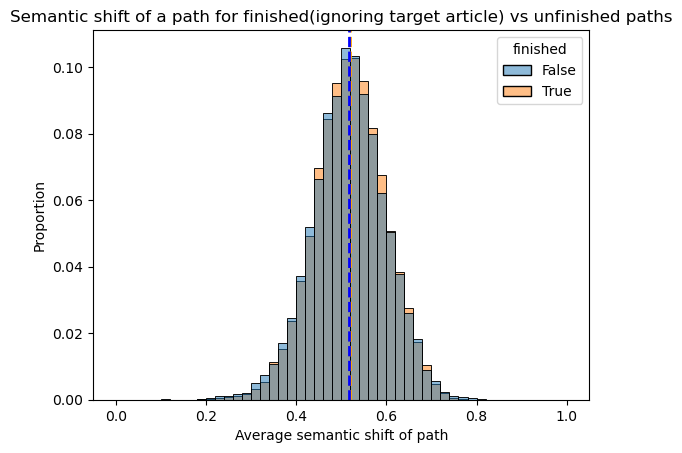

In [194]:
mean_semantic_shift_pf = df_cognitive_shift[df_cognitive_shift["finished"] == True]["average_semantic_shift_2"]
mean_semantic_shift_pf = [x for x in mean_semantic_shift_pf if ~np.isnan(x)]

mean_semantic_shift_uf = df_cognitive_shift[df_cognitive_shift["finished"] == False]["average_semantic_shift_2"]
mean_semantic_shift_uf = [x for x in mean_semantic_shift_uf if ~np.isnan(x)]

print(f"Semantic shift (finished paths): mean = {np.mean(mean_semantic_shift_pf):.4f} median = {np.median(mean_semantic_shift_pf):.4f}")
print(f"Semantic shift (unfinished paths): mean = {np.mean(mean_semantic_shift_uf):.4f} median = {np.median(mean_semantic_shift_uf):.4f}")
pval = stats.ttest_ind(mean_semantic_shift_pf, mean_semantic_shift_uf).pvalue
print("P-value = {} so the semantic shift between finished and unfinished paths is statistically different".format(pval))

sns.histplot(data=df_cognitive_shift, x="average_semantic_shift_2", hue="finished", multiple="layer", binwidth=0.02, binrange=[0,1], stat="proportion", common_norm = False, alpha=0.5)
plt.title("Semantic shift of a path for finished(ignoring target article) vs unfinished paths")
plt.xlabel("Average semantic shift of path")
plt.axvline(np.mean(mean_semantic_shift_pf), color='orange', linestyle='dashed', linewidth=2, label='Mean Finished')
plt.axvline(np.mean(mean_semantic_shift_uf), color='blue', linestyle='dashed', linewidth=2, label='Mean Unfinished')
plt.show()

We can see that just by removing the final semantic shift for finished paths, the average semantic shift for finished and unfinished paths becomes almost identical.

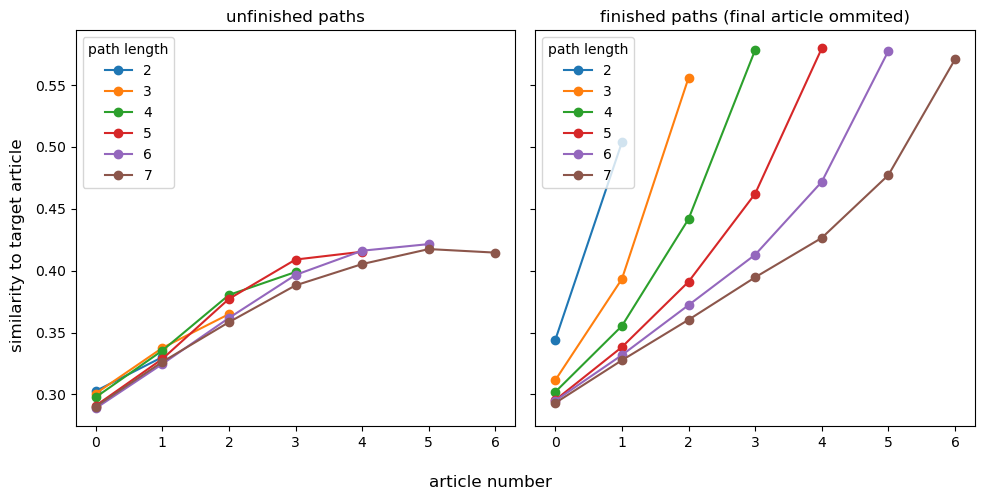

In [195]:
# min/max lengths of paths to include
min_length = 2
max_length = 7

df_uf_similarity = pd.DataFrame(index = [x for x in range (min_length, max_length + 1)], columns = [x for x in range (0, max_length)])
df_pf_similarity = pd.DataFrame(index = [x for x in range (min_length, max_length + 1)], columns = [x for x in range (0, max_length)])

for length in range (min_length, max_length + 1):
    similarities = df_cognitive_shift.loc[(df_cognitive_shift["finished"] == False) & (df_cognitive_shift["n_click"] == length)]["path_similarity"].tolist()
    similarities = np.nanmean(np.array(similarities), axis=0).tolist()
    similarities += [np.nan] * (max_length - length)
    df_uf_similarity.iloc[length - min_length] = similarities

    similarities = df_cognitive_shift.loc[(df_cognitive_shift["finished"] == True) & (df_cognitive_shift["n_click"] == length + 1)]["path_similarity"].tolist()
    # remove last node, always max semantic similarity because reached target
    similarities = [x[:-1] for x in similarities]
    similarities = np.nanmean(np.array(similarities), axis=0).tolist()
    similarities += [np.nan] * (max_length - length)
    df_pf_similarity.iloc[length - min_length] = similarities


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.supxlabel("article number")
fig.supylabel("similarity to target article")

x = [x for x in range (max_length)]
len_path = min_length
for it, row in df_uf_similarity.iterrows():
    axs[0].plot(x, row, marker = "o", label = len_path)
    axs[0].set_title("unfinished paths")
    axs[0].legend(title="path length", loc = "upper left")
    axs[0].xaxis.set_major_locator(plt.MultipleLocator(1))
    len_path += 1

len_path = min_length
for it, row in df_pf_similarity.iterrows():
    axs[1].plot(x, row, marker = "o", label = len_path)
    axs[1].set_title("finished paths (final article ommited)")
    axs[1].legend(title="path length", loc = "upper left")
    axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))
    len_path += 1

fig.tight_layout()

This links back to our observation earlier, unfinished paths stagnating after a few articles not being able to get the final push to reach the target.

## Conclusion

The difference in semantic shift between finished and unfinished paths is small but existant, with finished ones following a semantically closer path. This is largely due to the last couple of articles in finished paths being more semantically similar as they all relate to the target article. Ignoring the final semantic shift between before last article and target article in finished paths results in a nearly identical average semantic shift for finished and unfinished paths, revealing that it is not a factor of path abandonment.


# Structural Information

In [196]:
# Fei

## ML as Holistic view

In [197]:
# TODO